# **CMPE 258 - Assignment 5 Part C**
***Arpitha Gurumurthy***

Full end2end MLOps using PyTorch

**Data**: NYC's taxi-fare dataset
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

**Goal**: Predicting the fare price for a taxi ride in New York City given the pickup and dropoff locations.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/258_HW5'

In [ ]:
%cd /content/gdrive/My Drive/258_HW5

/content/gdrive/My Drive/258_HW5


In [ ]:
!ls

GCP-Coupons-Instructions.rtf  sample_submission.csv  train.csv
kaggle.json		      test.csv		     train.csv.zip


In [ ]:
# !kaggle competitions download -c new-york-city-taxi-fare-prediction

In [ ]:
!ls

GCP-Coupons-Instructions.rtf  sample_submission.csv  train.csv
kaggle.json		      test.csv		     train.csv.zip


In [ ]:
!unzip train.csv

Archive:  train.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Data Prep**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
## import libraries

#PyTorch 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

*Since the dataset is too huge, it is crashing the session on google colab even if the runtime type selected is GPU. Hence, taking only the first 50000 rows.*

In [ ]:
taxiFare_df = pd.read_csv('train.csv', nrows=100000)
taxiFare_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
taxiFare_df.shape

(100000, 8)

In [ ]:
test_df = pd.read_csv('test.csv', nrows=100000)
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


## **Helper Functions**

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [ ]:
from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()

In [ ]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


#def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3): ## if you want to add schedular
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

## **Implementing code in PyTorch**

In [ ]:
taxiFare_df = taxiFare_df.loc[taxiFare_df.fare_amount > 0]
taxiFare_df.fare_amount.min()

0.01

## **Feature Engineering**

In [ ]:
##Calculating distance travelled
taxiFare_df['distance'] = haversine_distance(taxiFare_df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
taxiFare_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [ ]:
taxiFare_df['EDTdate'] = pd.to_datetime(taxiFare_df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
taxiFare_df['Hour'] = taxiFare_df['EDTdate'].dt.hour
taxiFare_df['AMorPM'] = np.where(taxiFare_df['Hour']<12,'am','pm')
taxiFare_df['Weekday'] = taxiFare_df['EDTdate'].dt.strftime("%a")
taxiFare_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21,13,pm,Mon
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16,12,pm,Tue
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00,20,pm,Wed
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42,0,am,Sat
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00,3,am,Tue


## **Modeling**

In [ ]:
##Defining categoric and numeric columns
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']

In [ ]:
##using astype category on categoric columns
for col in taxiFare_df.columns:
  if col in cat_cols:
    taxiFare_df[col] = LabelEncoder().fit_transform(taxiFare_df[col])
    taxiFare_df[col]= taxiFare_df[col].astype('category')

In [ ]:
taxiFare_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21,13,1,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16,12,1,5
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00,20,1,6
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42,0,0,2
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00,3,0,5


In [ ]:
taxiFare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99988 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                99988 non-null  object        
 1   fare_amount        99988 non-null  float64       
 2   pickup_datetime    99988 non-null  object        
 3   pickup_longitude   99988 non-null  float64       
 4   pickup_latitude    99988 non-null  float64       
 5   dropoff_longitude  99988 non-null  float64       
 6   dropoff_latitude   99988 non-null  float64       
 7   passenger_count    99988 non-null  int64         
 8   distance           99988 non-null  float64       
 9   EDTdate            99988 non-null  datetime64[ns]
 10  Hour               99988 non-null  category      
 11  AMorPM             99988 non-null  category      
 12  Weekday            99988 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6), int64(1), obje

In [ ]:
taxiFare_df.columns


Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

## **Splitting into train and test**

In [ ]:
# keep only the cols for the model
Y = np.log(taxiFare_df.fare_amount)
df = taxiFare_df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']]

In [ ]:
len(taxiFare_df)

99988

In [ ]:
df_train = df[:99788]
df_test = df[99788:]
Y = Y[:99788]

In [ ]:
Y.shape

(99788,)

In [ ]:
Y.head()

0    1.504077
1    2.827314
2    1.740466
3    2.041220
4    1.667707
Name: fare_amount, dtype: float64

In [ ]:
df_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance
0,13,1,1,0.129633,-0.126246,0.127658,-0.128991,1,-0.049165
1,12,1,5,0.128025,-0.142299,0.138877,-0.142136,1,-0.028330
2,20,1,6,0.136047,-0.139186,0.133818,-0.143280,2,-0.048158
3,0,0,2,0.131531,-0.139596,0.135030,-0.143311,1,-0.044199
4,3,0,5,0.137129,-0.137817,0.139160,-0.139977,1,-0.046446


## **Processing numeric / continuous values**

In [ ]:
#Normalizing 
from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance
0,13,1,1,0.129633,-0.126246,0.127658,-0.128991,-0.518270,-0.049165
1,12,1,5,0.128025,-0.142300,0.138877,-0.142136,-0.518270,-0.028330
2,20,1,6,0.136047,-0.139186,0.133818,-0.143280,0.250895,-0.048158
3,0,0,2,0.131531,-0.139596,0.135030,-0.143311,-0.518270,-0.044199
4,3,0,5,0.137129,-0.137817,0.139160,-0.139977,-0.518270,-0.046446


In [ ]:
X.shape

(99788, 9)

## **Splitting into training and test data**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance
45881,21,1,3,0.135838,-0.139515,0.133072,-0.142010,-0.51827,-0.047255
2817,18,1,6,0.127444,-0.141945,0.130900,-0.142377,-0.51827,-0.041491
31922,17,1,0,0.137492,-0.138976,0.136006,-0.141855,-0.51827,-0.049913
1512,14,1,2,0.137259,-0.139303,0.138085,-0.142757,-0.51827,-0.049444
66434,4,0,3,0.141089,-0.138311,0.140470,-0.140801,-0.51827,-0.050129


## **Embeddings**

In [ ]:
#df.info()
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
type(emb_szs)

list

## **Building the model**
Pytorch data set datasets and dataloaders


In [ ]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [ ]:
train_ds = RegressionColumnarDataset(X_train, cat_cols, y_train) 
val_ds = RegressionColumnarDataset(X_val, cat_cols, y_val) 

In [ ]:
params = {'batch_size': 128,
          'shuffle': True}
traindl = DataLoader(train_ds, **params) 
valdl = DataLoader(val_ds, **params) 

## **Model for Tabular data**

In [ ]:
torch.manual_seed(33)


In [ ]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 6.357980839857643)

In [ ]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

## **Optimizer**

In [ ]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=

lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

## **Training**

In [ ]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 0.2729 train_rmse: 0.5224 | val_loss: 0.2367 val_rmse: 0.4865


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 0.1707 train_rmse: 0.4132 | val_loss: 0.1682 val_rmse: 0.4100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 0.1459 train_rmse: 0.3820 | val_loss: 0.1290 val_rmse: 0.3592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 0.1126 train_rmse: 0.3356 | val_loss: 0.1116 val_rmse: 0.3340


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 0.1065 train_rmse: 0.3262 | val_loss: 0.1089 val_rmse: 0.3300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 0.1044 train_rmse: 0.3231 | val_loss: 0.1075 val_rmse: 0.3279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 0.1039 train_rmse: 0.3223 | val_loss: 0.1087 val_rmse: 0.3297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 0.1034 train_rmse: 0.3216 | val_loss: 0.1098 val_rmse: 0.3314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 0.1041 train_rmse: 0.3227 | val_loss: 0.1029 val_rmse: 0.3208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 0.1034 train_rmse: 0.3216 | val_loss: 0.1123 val_rmse: 0.3351



## **Visualizations**

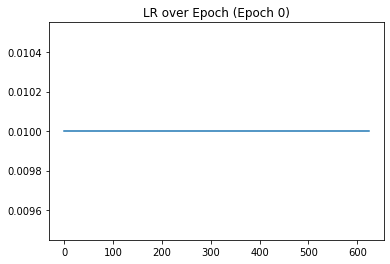

In [ ]:
#Plot the Learning rate
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')


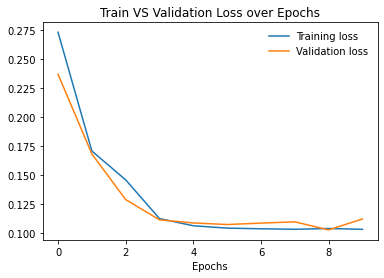

In [ ]:
#inspired from: https://nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb 
# Train VS Validaton Loss

t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

## **Testing**

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 99800 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               200 non-null    category
 1   AMorPM             200 non-null    category
 2   Weekday            200 non-null    category
 3   pickup_latitude    200 non-null    float64 
 4   pickup_longitude   200 non-null    float64 
 5   dropoff_latitude   200 non-null    float64 
 6   dropoff_longitude  200 non-null    float64 
 7   passenger_count    200 non-null    float64 
 8   distance           200 non-null    float64 
dtypes: category(3), float64(6)
memory usage: 12.8 KB


In [ ]:
# divide to cats and conts columns + make them a tensor + to.cuda()
df_test_cats = df_test[['Hour', 'AMorPM', 'Weekday']]
test_cats = df_test_cats.astype(np.int64)
test_cats = torch.tensor(test_cats.values).cuda()

df_test_conts = df_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']]
test_conts = df_test_conts.astype(np.float32)
test_conts = torch.tensor(test_conts.values).cuda()

In [ ]:
# make prediction

with torch.no_grad():
    model.eval()
    output = model.forward(test_cats,test_conts).cuda()

In [ ]:
output

tensor([2.0652, 2.6576, 2.0439, 1.4161, 2.3621, 1.4212, 2.8025, 2.9155, 2.5724,
        3.0111, 2.2392, 2.1247, 2.7149, 2.0407, 2.1896, 1.9078, 2.0960, 2.1039,
        2.6558, 1.3766, 1.4967, 1.3856, 1.4877, 2.5474, 2.4473, 2.1160, 2.3834,
        2.2483, 2.9163, 6.3580, 1.9455, 1.9938, 3.2789, 2.8364, 3.2301, 3.2247,
        2.3966, 2.5620, 1.8862, 3.0138, 2.5675, 1.6885, 3.0646, 1.3947, 2.3767,
        2.6063, 1.3731, 2.5043, 1.4003, 1.6464, 1.7415, 2.1470, 1.5654, 2.3491,
        1.6721, 1.3260, 3.2087, 1.7173, 1.5086, 1.8562, 1.7112, 2.1555, 1.4380,
        1.9853, 2.8630, 2.9733, 2.1774, 3.2351, 1.3968, 1.3904, 1.8217, 1.4177,
        1.7946, 1.9880, 1.4315, 2.3273, 1.3386, 2.4927, 1.8138, 2.2810, 1.9481,
        1.9511, 1.8711, 1.3604, 3.1532, 2.1675, 1.5022, 2.4833, 1.8783, 2.1061,
        2.1971, 3.1308, 2.1608, 2.5494, 1.5176, 2.5352, 2.6426, 2.0626, 2.2891,
        2.1697, 2.9778, 1.6189, 1.4602, 1.7533, 2.0727, 3.2520, 1.3777, 1.6852,
        1.5317, 2.2612, 1.4047, 3.4126, 

In [ ]:
len(output)

200

In [ ]:
type(output)


torch.Tensor

In [ ]:
# convert to numpy array
np_output = output.cpu().numpy()


In [ ]:
type(np_output)


numpy.ndarray

In [ ]:
np_output

array([2.0651932, 2.6576045, 2.0439143, 1.4161316, 2.3620641, 1.4211874,
       2.8025239, 2.9155421, 2.5723712, 3.0110784, 2.2391686, 2.1247203,
       2.714892 , 2.0406988, 2.1896355, 1.9078408, 2.0959592, 2.103852 ,
       2.6557703, 1.3765802, 1.4967381, 1.3856312, 1.4876745, 2.5473719,
       2.4473252, 2.116049 , 2.3834226, 2.2483058, 2.9162543, 6.3579807,
       1.9455267, 1.9937817, 3.278889 , 2.8364112, 3.2300832, 3.2246637,
       2.3965526, 2.5620432, 1.8861605, 3.0138283, 2.5675416, 1.6885419,
       3.0645792, 1.3946949, 2.3767376, 2.606345 , 1.3730578, 2.5043306,
       1.4003274, 1.6463977, 1.7415196, 2.1469624, 1.5654151, 2.3491383,
       1.6720688, 1.3260411, 3.2086873, 1.7173035, 1.5086485, 1.8562194,
       1.7111635, 2.1555438, 1.4379547, 1.9853431, 2.862952 , 2.9733253,
       2.1773696, 3.2350893, 1.3967572, 1.3904454, 1.8216581, 1.417708 ,
       1.7946064, 1.9880056, 1.431452 , 2.327259 , 1.3386325, 2.4926796,
       1.8138367, 2.280984 , 1.9480522, 1.9510696, 

In [ ]:
#  exp to the output data

np_output_exp = np.exp(np_output)


In [ ]:
np_output_exp

array([  7.8868213,  14.262083 ,   7.7207713,   4.121147 ,  10.612835 ,
         4.1420355,  16.486202 ,  18.458817 ,  13.096843 ,  20.30929  ,
         9.385526 ,   8.370556 ,  15.102978 ,   7.6959853,   8.931957 ,
         6.7385235,   8.133239 ,   8.197687 ,  14.235948 ,   3.9613314,
         4.4670935,   3.997348 ,   4.426789 ,  12.773489 ,  11.557391 ,
         8.298286 ,  10.841947 ,   9.471675 ,  18.471966 , 577.0799   ,
         6.997317 ,   7.343251 ,  26.546263 ,  17.054451 ,  25.281761 ,
        25.145117 ,  10.98524  ,  12.962275 ,   6.5940027,  20.365213 ,
        13.033742 ,   5.4115844,  21.425446 ,   4.033744 ,  10.769711 ,
        13.549437 ,   3.9474027,  12.235366 ,   4.056528 ,   5.1882567,
         5.7060065,   8.558821 ,   4.784661 ,  10.476538 ,   5.323169 ,
         3.766104 ,  24.74658  ,   5.56949  ,   4.520617 ,   6.399497 ,
         5.535398 ,   8.632584 ,   4.212072 ,   7.281545 ,  17.51315  ,
        19.556843 ,   8.823068 ,  25.40864  ,   4.042071 ,   4.0

In [ ]:
# CONVERT to pandas data frame 
df_output =  pd.DataFrame(np_output_exp)

In [ ]:
df_output

,0
0,7.886821
1,14.262083
2,7.720771
3,4.121147
4,10.612835
...,...
195,5.914444
196,7.223669
197,4.706256
198,4.379322


In [ ]:
type(df_output)

pandas.core.frame.DataFrame

## **References:**
1. https://github.com/offirinbar/NYC_Taxi/blob/master/NYC_Taxi_PyTorch.ipynb
2. https://towardsdatascience.com/deep-learning-using-pytorch-for-tabular-data-c68017d8b480